In [1]:
import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
import laspy
from scipy import ndimage
from tqdm import tqdm
from matplotlib import pyplot as plt
import os

import numpy as np
import laspy
from scipy import ndimage
import os

In [2]:
def print_las_info(las_path):
    """
    Выводит основную информацию о LAS/LAZ файле:
    количество точек, границы (X, Y, Z), размер области и примерную плотность.
    x, y - 
    z - высота
    """
    with laspy.open(las_path) as f:
        header = f.header
        num_points = header.point_count
        min_x, max_x = header.mins[0], header.maxs[0]
        min_y, max_y = header.mins[1], header.maxs[1]
        min_z, max_z = header.mins[2], header.maxs[2]

        width = max_x - min_x
        lenght = max_y - min_y
        area = width * lenght if width > 0 and lenght > 0 else np.nan
        density = num_points / area if area and not np.isnan(area) else np.nan

        print(f"\nФайл: {os.path.basename(las_path)}")
        print(f"Формат версии: {header.version}")
        print(f"Количество точек: {num_points:,}")
        print(f"Диапазон координат (X, Y, Z):")
        print(f"  X: {min_x:.2f} - {max_x:.2f}  (ширина {width:.2f} м)")
        print(f"  Y: {min_y:.2f} - {max_y:.2f}  (размах {lenght:.2f} м)")
        print(f"  Z: {min_z:.2f} - {max_z:.2f}  (высота {max_z - min_z:.2f} м)")
        print(f"Площадь покрытия: {area/1e6:.2f} км²")

        print(f"Средняя плотность: {density:.2f} точек/м²\n")

        # Первые несколько точек
        print("Пример точек:")
        for points in f.chunk_iterator(3):
            for i in range(3):
                print(f"x: {points.x[i]:.2f} y: {points.y[i]:.2f} z: {points.z[i]:.2f}")
            break

In [3]:
def print_array_data(data):
    data = np.array(data)
    print(data.shape)
    print(f"{data.min():.2f} - {data.max():.2f}")
    print(data.mean())
    counts, bins = np.histogram(data)
    plt.stairs(counts, bins)

In [ ]:
# PMF
def update_ground_mask(points, 
                       grid_opened, 
                       ground_mask, 
                       min_x, min_y, 
                       cell_size, 
                       current_threshold):

    # Размеры сетки
    rows, cols = grid_opened.shape
    # Загружаем точки
    x, y, z = points[:, 0], points[:, 1], points[:, 2]

    # Для кажой точки находим ее индекс в сетке
    col_idx = np.floor((x - min_x) / cell_size).astype(np.int32)
    row_idx = np.floor((y - min_y) / cell_size).astype(np.int32)

    # Маска точек, попадающих внутрь сетки
    valid = (row_idx >= 0) & (row_idx < rows) & (col_idx >= 0) & (col_idx < cols)
    row_idx, col_idx, z_valid = row_idx[valid], col_idx[valid], z[valid]

    # Извлекаем значения из открытой поверхности
    opened_vals = grid_opened[row_idx, col_idx]

    # Проверяем условие
    mask_valid = (z_valid - opened_vals) <= current_threshold

    # Обновляем исходную маску (дизъюнкция с перведущей)
    ground_mask[valid] |= mask_valid

    return ground_mask


def progressive_morphological_filter(points,
                                     cell_size=1.0,
                                     max_window_size=20, 
                                     initial_threshold=0.5, 
                                     slope=0.3):
    

    min_x, min_y = np.min(points[:, :2], axis=0)
    max_x, max_y = np.max(points[:, :2], axis=0)
    
    

    # find lovest points --------

    # Построение пространственной сетки
    cols = np.ceil((max_x - min_x) / cell_size).astype(int)
    rows = np.ceil((max_y - min_y) / cell_size).astype(int)
    grid = np.full((rows, cols), np.inf, dtype=np.float32)
    
    # Для кажой точки находим ее индекс в сетке
    col_idx = np.floor((points[:,0] - min_x) / cell_size).astype(np.int64)
    row_idx = np.floor((points[:,1] - min_y) / cell_size).astype(np.int64)

    # Проверка чтобы точки не вышли за сетку
    valid = (row_idx >= 0) & (row_idx < rows) & (col_idx >= 0) & (col_idx < cols)
    row_idx = row_idx[valid]
    col_idx = col_idx[valid]

    # отделяем z координаты в одномерный массив
    z_vals  = points[valid, 2].astype(np.float32)

    # Сводим друмерную сетку к одномерной
    flat_idx = row_idx * cols + col_idx
    flat_grid = grid.ravel()

    # Находим минимум среди всех z_vals с одним индексом
    # и помещаем в flat_grid
    np.minimum.at(flat_grid, flat_idx, z_vals)

    # возвращаем сетку в двумерный вид
    grid = flat_grid.reshape((rows, cols))

    # ------------

    # Пуская маска земли
    ground_mask = np.zeros(len(points), dtype=bool)

    # Возможные значаения окон
    window_sizes = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
        
    for window_size in window_sizes:
        if window_size > max_window_size:
            break
            
        footprint = np.ones((window_size, window_size))
        eroded = ndimage.grey_erosion(grid, footprint=footprint)
        opened = ndimage.grey_dilation(eroded, footprint=footprint)
        current_threshold = initial_threshold + slope * (window_size / 2) * cell_size

        ground_mask = update_ground_mask(points, 
                                         opened, 
                                         ground_mask, 
                                         min_x, min_y,
                                         cell_size,
                                         current_threshold)
    
    return ground_mask

In [ ]:
folder_path = "/home/chazelam/Code/LiDAR/5+1_split_output"
file_names = os.listdir(folder_path)
# file_name = os.path.join(folder_path, file_names[0])
file_name = os.path.join(folder_path, "tile_4_4.las")


las = laspy.read(file_name)
points = np.vstack((las.x, las.y, las.z)).T
print(f"file contain {len(points):,} points")

43,005,548


In [ ]:

output_dir = "PMF_out"
os.makedirs(output_dir, exist_ok=True)

# PMF 
cell_size=0.5
max_window_size=15
initial_threshold=0.3
slope=0.2

ground_mask = progressive_morphological_filter(points = points,
                                                cell_size = cell_size,
                                                max_window_size = max_window_size, 
                                                initial_threshold = initial_threshold, 
                                                slope = slope)


non_ground_mask = ~ground_mask

non_ground_path = os.path.join(output_dir, "non_ground.las")
non_ground = las[non_ground_mask]
non_ground.write(non_ground_path)

print(f"Saved {non_ground.header.point_count:,} points to {non_ground_path}")


ground_path = os.path.join(output_dir, "ground.las")
ground = las[ground_mask]
ground.write(ground_path)

print(f"Saved {ground.header.point_count:,} points to {ground_path}")

In [4]:
folder_path = "/home/chazelam/Code/LiDAR/PMF_out"
file_name = os.path.join(folder_path, "non_ground.las")

print_las_info(file_name)


Файл: non_ground.las
Формат версии: 1.2
Количество точек: 18,880,083
Диапазон координат (X, Y, Z):
  X: 3.85 - 10.85  (ширина 7.00 м)
  Y: -3.03 - 3.97  (размах 7.00 м)
  Z: -1.56 - 18.82  (высота 20.39 м)
Площадь покрытия: 0.00 км²
Средняя плотность: 385417.93 точек/м²

Пример точек:
x: 6.08 y: -2.18 z: -1.40
x: 6.09 y: -2.18 z: -1.41
x: 6.09 y: -2.18 z: -1.41


In [5]:
las = laspy.read(file_name)
points = np.vstack((las.x, las.y, las.z)).T
print(f"Loaded {len(points):,} points")

Loaded 18,880,083 points


In [6]:
tree = cKDTree(points)

In [ ]:
counts_small = tree.query_ball_point(points, r=0.1, workers=-1, return_length=True)

print(counts_small)

(4128523,)
1.00 - 2587.00
409.6002732696415


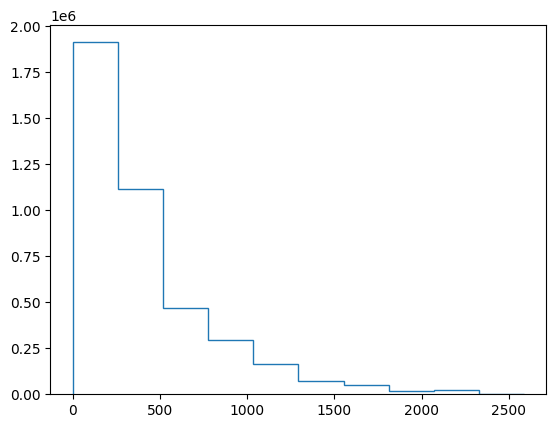

In [ ]:
print_array_data(counts_small)

In [ ]:
counts_large = tree.query_ball_point(points, r=1, workers=-1, return_length=True)

print(counts_large)

[1181 1182 1205 ... 4081 4076 3998]


(4128523,)
34.00 - 92322.00
28259.556346664413


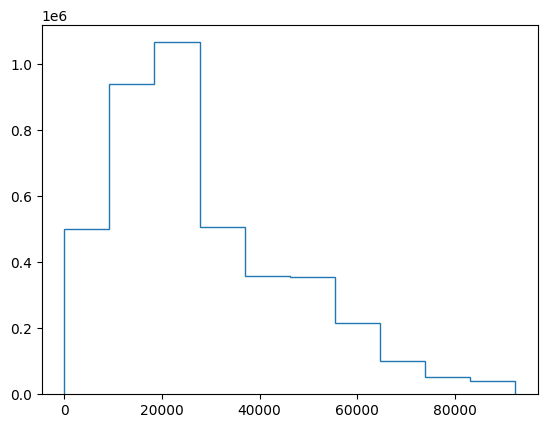

In [ ]:
print_array_data(counts_large)

In [ ]:
rel_density = counts_large / counts_small

(4128523,)
1.09 - 74415.00
161.54220849538856


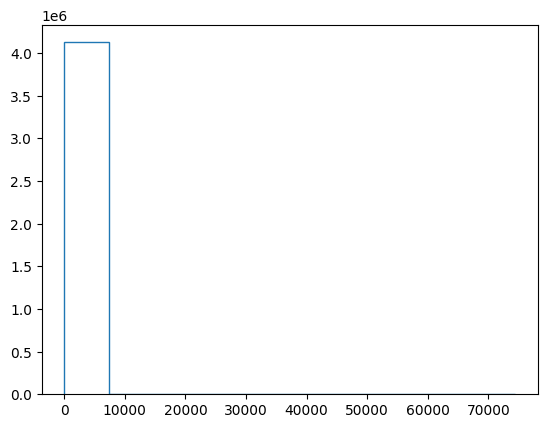

In [ ]:
print_array_data(rel_density)

In [ ]:
density_threshold = 700

mask = density > density_threshold

las = laspy.read("non_ground.las")
points = np.vstack((las.x, las.y, las.z)).transpose()

print(f"Tree points: {np.sum(mask)}")
print(f"Non tree points: {np.sum(~mask)}")

ground_points     = points[mask]
non_ground_points = points[~mask]


save_las_points(las, ground_points, "con_v3.las")
save_las_points(las, non_ground_points, "non_con.las")

In [ ]:
candidates = np.vstack(candidates)
print(candidates.shape)

(777823, 3)


In [ ]:
las = laspy.read(las_path)

save_las_points(las, candidates, "can.las")

Saved 777,823 points to can.las


In [ ]:
print_las_info("can.las")


Файл: can.las
Формат версии: 1.2
Количество точек: 777,823
Диапазон координат (X, Y, Z):
  X: -0.15 - 39.85  (ширина 40.00 м)
  Y: -61.56 - -27.03  (размах 34.53 м)
  Z: 0.50 - 12.00  (высота 11.50 м)
Площадь покрытия: 0.00 км²
Средняя плотность: 563.17 точек/м²

Пример точек:
x: -0.07 y: -60.33 z: 8.00
x: -0.10 y: -60.33 z: 8.02
x: -0.07 y: -60.32 z: 8.02


### Фильтрация кандидатов

In [ ]:
tree = cKDTree(candidates, leafsize=16)
neighbors = tree.query_ball_point(candidates, r=1)
counts = np.fromiter((len(lst) for lst in neighbors), dtype=np.int32)

In [ ]:
N = candidates.shape[0]
tree = cKDTree(candidates, leafsize=16)
counts = np.empty(N, dtype=np.int32)

# Обход по чанкам, чтобы не получить гигантские списки
for start in range(0, N, chunk_size):
    end = min(N, start + chunk_size)
    # query_ball_point возвращает список списков индексов
    neighbors = tree.query_ball_point(candidates[start:end, :], r=0.1)
    # длины списков = количество соседей
    counts[start:end] = np.fromiter((len(lst) for lst in neighbors), dtype=np.int32)

In [ ]:
# Порог: если в окрестности мало соседей, то - шум
print(counts)
print(f"{min(counts)} - {max(counts)}")
print(np.mean(counts))
print(np.average(counts))
mask = counts > 50

candidates_v2 = candidates[mask]
print(candidates_v2.shape)

[ 7  9  9 ... 11  8  8]
1 - 555
92.27824710763245
92.27824710763245
(438773, 3)


In [ ]:
print(sum(counts))

las = laspy.read(las_path)

save_las_points(las, candidates_v2, "can_v2.las")

71776143
Saved 438,773 points to can_v2.las
